In [1]:
import os
import pandas as pd

def build_metadata(base_path='dogs_split'):
    """Build a dataframe with image paths and their breed labels."""
    records = []
    
    for split in ['train', 'test', 'val']:
        # Path to the images folder for this split
        images_path = os.path.join(base_path, split, 'images')
        
        # Check if the images folder exists
        if not os.path.isdir(images_path):
            print(f"Warning: Images folder not found at {images_path}")
            continue
            
        print(f"Processing {split} images...")
        
        # List all breed folders in the images directory
        breed_folders = [f for f in os.listdir(images_path) 
                        if os.path.isdir(os.path.join(images_path, f))]
        
        for breed_folder in breed_folders:
            # Extract breed name from folder (e.g., 'n02085620-Chihuahua' -> 'Chihuahua')
            if '-' in breed_folder:
                breed_name = breed_folder.split('-', 1)[-1]
            else:
                breed_name = breed_folder
                
            breed_path = os.path.join(images_path, breed_folder)
            
            # List all image files in the breed folder
            image_files = [f for f in os.listdir(breed_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.jfif'))]
            
            for img_file in image_files:
                img_path = os.path.join(breed_path, img_file)
                
                # Get the corresponding annotation path
                # Assuming annotation files have the same name but without extension
                # or with .xml extension
                img_name_without_ext = os.path.splitext(img_file)[0]
                annotation_path = os.path.join(
                    base_path, split, 'annotation', breed_folder, img_name_without_ext
                )
                
                # Check if annotation exists (could be .xml or no extension)
                if os.path.exists(annotation_path):
                    ann_path = annotation_path
                elif os.path.exists(annotation_path + '.xml'):
                    ann_path = annotation_path + '.xml'
                else:
                    ann_path = None
                
                records.append({
                    'image_path': img_path,
                    'annotation_path': ann_path,
                    'breed': breed_name,
                    'split': split
                })
    
    print(f"Total images found: {len(records)}")
    return pd.DataFrame(records)

# Build the metadata
meta_df = build_metadata('dogs_split')

# Display results
if not meta_df.empty:
    print(f"\nDataFrame shape: {meta_df.shape}")
    print(f"Images per split:\n{meta_df['split'].value_counts()}")
    print(f"Number of unique breeds: {meta_df['breed'].nunique()}")
else:
    print("No images found.")
    
    

Processing train images...
Processing test images...
Processing val images...
Total images found: 20580

DataFrame shape: (20580, 4)
Images per split:
split
train    14355
test      3200
val       3025
Name: count, dtype: int64
Number of unique breeds: 120


In [2]:
meta_df.sample(10)

,image_path,annotation_path,breed,split
16187,dogs_split\test\images\n02102177-Welsh_springe...,dogs_split\test\annotation\n02102177-Welsh_spr...,Welsh_springer_spaniel,test
15523,dogs_split\test\images\n02096177-cairn\n020961...,dogs_split\test\annotation\n02096177-cairn\n02...,cairn,test
20323,dogs_split\val\images\n02112137-chow\n02112137...,dogs_split\val\annotation\n02112137-chow\n0211...,chow,val
10806,dogs_split\train\images\n02108000-EntleBucher\...,dogs_split\train\annotation\n02108000-EntleBuc...,EntleBucher,train
8883,dogs_split\train\images\n02105056-groenendael\...,dogs_split\train\annotation\n02105056-groenend...,groenendael,train
4110,dogs_split\train\images\n02093859-Kerry_blue_t...,dogs_split\train\annotation\n02093859-Kerry_bl...,Kerry_blue_terrier,train
9438,dogs_split\train\images\n02105641-Old_English_...,dogs_split\train\annotation\n02105641-Old_Engl...,Old_English_sheepdog,train
8359,dogs_split\train\images\n02102318-cocker_spani...,dogs_split\train\annotation\n02102318-cocker_s...,cocker_spaniel,train
12307,dogs_split\train\images\n02111129-Leonberg\n02...,dogs_split\train\annotation\n02111129-Leonberg...,Leonberg,train
7563,dogs_split\train\images\n02100735-English_sett...,dogs_split\train\annotation\n02100735-English_...,English_setter,train


SPLITTING THE SAMPLES TO TRAIN, TEST AND VAL

In [3]:
import tensorflow as tf
import numpy as np

train_df = meta_df[meta_df["split"] == "train"]
test_df = meta_df[meta_df["split"] == "test"]
val_df = meta_df[meta_df["split"] == "val"]

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Validation samples: {len(val_df)}")


Training samples: 14355
Test samples: 3200
Validation samples: 3025


CREATING A FUNCTION TO LOAD AND PREPROCESS AN IMAGE

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, [224, 224])


    image = preprocess_input(image)

    return image, label


PREPARING THE LABELS(LIKE CHIHUAHUA) TO NUMBERS(0,1,2,..)

In [15]:
from sklearn.preprocessing import LabelEncoder

# Creating a label encoder
label_encoder = LabelEncoder()

# getting all the unique breed names from the meta_df
all_breeds = meta_df["breed"].unique()
# fitting internally sorts the label alphabetically
# the encoder learns the mapping from breed
label_encoder.fit(all_breeds)

# Converts each breed string into its numeric label using
# uses same mapping for all
train_df["label"] = label_encoder.transform(train_df["breed"])
val_df["label"] = label_encoder.transform(val_df["breed"])
test_df["label"] = label_encoder.transform(test_df["breed"])

print(f"Number of classes: {len(label_encoder.classes_)}")


Number of classes: 120


C:\Users\Aman\AppData\Local\Temp\ipykernel_19296\2839506772.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = label_encoder.transform(train_df["breed"])
C:\Users\Aman\AppData\Local\Temp\ipykernel_19296\2839506772.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["label"] = label_encoder.transform(val_df["breed"])
C:\Users\Aman\AppData\Local\Temp\ipykernel_19296\2839506772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

CREATING THE TENSORFLOW DATASET

In [16]:
def augment_image(image, label):
    # image in [-1,1]
    image = (image + 1.0) / 2.0    # temporarily map to [0,1] for tf.image ops
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.random_saturation(image, 0.9, 1.1)
    image = tf.clip_by_value(image, 0.0, 1.0)
    image = image * 2.0 - 1.0      # back to [-1,1]
    return image, label

def create_dataset(df, batch_size = 32, shuffle = False, augment = False ):
    # Extract paths and labels
    path = df["image_path"].values
    labels = df["label"].values

    # create dataset from tensors
    # internally (img1, 2) (img2, 54),.. etc.
    dataset = tf.data.Dataset.from_tensor_slices((path, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size = 1000)


    # for each element in the dataset, the dataset.map(fn) calls fn(element) automatically.
    dataset = dataset.map(
        load_and_preprocess_image, 
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            augment_image, 
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # batching the data
    dataset = dataset.batch(batch_size)

    # prefecting next batch
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

train_dataset_augmented = create_dataset(train_df, batch_size=32, shuffle=True, augment=True)
test_dataset = create_dataset(test_df, batch_size=32, shuffle=False)
val_dataset = create_dataset(val_df, batch_size=32, shuffle=False)

In [17]:
for images, labels in train_dataset_augmented.take(1): 
    print("Image shape", images.shape)
    print("labels shape", labels.shape)


Image shape (32, 224, 224, 3)
labels shape (32,)


In [18]:
for images, _ in train_dataset_augmented.take(1):
    print(tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())

-1.0 1.0


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [20]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape= (224, 224, 3)
)

print("MobileNetV2 loaded succesfully!")
print(f"Input shape: {base_model.input_shape}")
print(f"Output Shape: {base_model.output_shape}")

MobileNetV2 loaded succesfully!
Input shape: (None, 224, 224, 3)
Output Shape: (None, 7, 7, 1280)


FREEZING ALL THE LAYERS IN THE BASE MODEL

In [21]:
# we freeze the layers because we dont want the base leyrs to update the weight
base_model.trainable = False
print(f"Number of layers in the base model: {len(base_model.layers)}")
print(f"Trainable layers: {sum([layer.trainable for layer in base_model.layers])}")

Number of layers in the base model: 154
Trainable layers: 0


BUILDING OUR CUSTOM CNN CLASSIFIER

In [22]:
def build_dog_breed_model(base_model, num_classes=120):
    # Here we build our complete model for our dog breed classification.

    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = base_model(inputs, training=False) # shape = (32, 7, 7, 1280)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.35)(x)



    x = layers.Dense(256, activation="relu",kernel_regularizer=regularizers.l2(0.001))(x)

    # dropout
    x = layers.Dropout(0.35)(x)

    # Final dense layer: 120 neurons for 120 classes
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(0.001))(x)

    # Creating the complete model
    model = models.Model(inputs = inputs, outputs = outputs)

    return model

model_phase1 = build_dog_breed_model(base_model, num_classes=120)

model_phase1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',# becuase our labels are int, not one hot-encoded
    metrics=["accuracy",tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top_5")],
    
)
print("Model complied Successfully!!")

model_phase1.summary()

Model complied Successfully!!
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               327936    
                                                                 
 dropout_6 (Dropout)         

TRAINING THE DATASET(FEATURE EXTRACTION ONLY)

In [23]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True,
        verbose=1
    )
]
print("Early stopping added.")

print("="*60)
print("STARTING INITIAL TRAINING(FEATURE EXTRACTION)")
print("="*60)
print("Training only our dense layers. Keeping MobileNetV2 frozen")
print("="*60)

history1 = model_phase1.fit(
    train_dataset_augmented,
    validation_data = val_dataset,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)
print("Initial training complete!")

Early stopping added.
STARTING INITIAL TRAINING(FEATURE EXTRACTION)
Training only our dense layers. Keeping MobileNetV2 frozen
Epoch 1/15
449/449 [==============================] - 54s 117ms/step - loss: 5.1701 - accuracy: 0.0770 - top_5: 0.1177 - val_loss: 4.6806 - val_accuracy: 0.2271 - val_top_5: 0.0056
Epoch 2/15
449/449 [==============================] - 51s 113ms/step - loss: 3.7362 - accuracy: 0.2977 - top_5: 0.0695 - val_loss: 3.1095 - val_accuracy: 0.4671 - val_top_5: 0.0056
Epoch 3/15
449/449 [==============================] - 54s 120ms/step - loss: 2.5023 - accuracy: 0.5111 - top_5: 0.0628 - val_loss: 2.3002 - val_accuracy: 0.5855 - val_top_5: 0.0122
Epoch 4/15
449/449 [==============================] - 54s 120ms/step - loss: 2.0053 - accuracy: 0.6149 - top_5: 0.0505 - val_loss: 1.9368 - val_accuracy: 0.6436 - val_top_5: 0.0136
Epoch 5/15
449/449 [==============================] - 54s 120ms/step - loss: 1.7757 - accuracy: 0.6686 - top_5: 0.0496 - val_loss: 1.7559 - val_accur

In [ ]:
def build_dog_breed_model_unfrozen(base_model, num_classes=120):

    base_model.trainable = True

    for layer in base_model.layers[:-20]:
        layer.trainable = False

    unfrozen_count = sum([layer.trainable for layer in base_model.layers])
    print(f"Unfroze {unfrozen_count} layers of MobileNetV2")

    # building the model
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.2)(x)

    # First Desnse layer with regularization
    x = layers.Dense(256, activation="relu",kernel_regularizer=regularizers.l2(1e-4))(x)

    # dropout
    x = layers.Dropout(0.2)(x)

    # Final dense layer: 120 neurons for 120 classes
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(1e-4))(x)

    # modell
    model = models.Model(inputs = inputs, outputs = outputs)

    return model

print("\n" + "="*60)
print("PHASE 2: Fine-tuning MobileNetV2 layers")
print("="*60)

# 1. Build Phase 2 model
model_phase2 = build_dog_breed_model_unfrozen(base_model, num_classes=120)

# 2. CRITICAL: Transfer weights from Phase 1 to Phase 2
print("Transferring learned weights from Phase 1...")
phase1_weights = model_phase1.get_weights()
model_phase2.set_weights(phase1_weights)
print("Weights transferred successfully!")

# 3. Count trainable layers (optional verification)
trainable_count = sum([layer.trainable for layer in model_phase2.layers])
print(f"Trainable layers in Phase 2 model: {trainable_count}")


PHASE 2: Fine-tuning MobileNetV2 layers
Unfroze 20 layers of MobileNetV2
Transferring learned weights from Phase 1...
Weights transferred successfully!
Trainable layers in Phase 2 model: 7


In [92]:
model_phase2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               327936    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0   

In [25]:

# Recompile with tiny learning rate
model_phase2.compile(
    optimizer=Adam(learning_rate=0.00001),  # 10x smaller than phase 1
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks2 = [
    EarlyStopping(
        monitor="val_loss",
        patience=6,  # Maybe more patience for fine-tuning
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,  # More patience for reducing LR
        min_lr=1e-7,
        verbose=1
    )
]

extra_epochs = 10
start_epoch = len(history1.epoch)
end_epoch = start_epoch + extra_epochs 

history2 = model_phase2.fit(
    train_dataset_augmented,
    validation_data=val_dataset,
    epochs=end_epoch,
    initial_epoch=start_epoch,
    callbacks=callbacks2,
    verbose=1
)

print("Fine-tuning complete!")
print(f"Total training epochs: {len(history1.epoch) + len(history2.epoch)}")


Epoch 16/25
449/449 [==============================] - 62s 132ms/step - loss: 0.5581 - accuracy: 0.8376 - val_loss: 0.7746 - val_accuracy: 0.7785 - lr: 1.0000e-05
Epoch 17/25
449/449 [==============================] - 59s 132ms/step - loss: 0.5082 - accuracy: 0.8535 - val_loss: 0.7756 - val_accuracy: 0.7792 - lr: 1.0000e-05
Epoch 18/25
449/449 [==============================] - 59s 132ms/step - loss: 0.4783 - accuracy: 0.8625 - val_loss: 0.7834 - val_accuracy: 0.7792 - lr: 1.0000e-05
Epoch 19/25
449/449 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8681
Epoch 19: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
449/449 [==============================] - 58s 129ms/step - loss: 0.4640 - accuracy: 0.8681 - val_loss: 0.7869 - val_accuracy: 0.7782 - lr: 1.0000e-05
Epoch 20/25
449/449 [==============================] - 58s 129ms/step - loss: 0.4950 - accuracy: 0.8600 - val_loss: 0.6784 - val_accuracy: 0.8056 - lr: 3.0000e-06
Epoch 21/25
449/449 [=

In [26]:
test_loss, test_accuracy = model_phase2.evaluate(test_dataset, verbose=1)
print(f"\nFINAL TEST ACCURACY: {test_accuracy:.2%}")

100/100 [==============================] - 10s 94ms/step - loss: 0.6940 - accuracy: 0.8047

FINAL TEST ACCURACY: 80.47%


In [27]:
model_phase2.save('dog_breed_classifier_final.h5')

In [90]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import joblib

model = model_phase2 

def preprocess_image(image_path, target_size=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)

    # IMPORTANT: same normalization as training
    image = preprocess_input(image)

    image = tf.expand_dims(image, axis=0)  # batch dimension
    return image

def predict_dog_breed(image_path, model, top_k=5):
    img = preprocess_image(image_path)

    predictions = model.predict(img, verbose=0)[0]

    top_k_idx = np.argsort(predictions)[-top_k:][::-1]
    top_k_breeds = label_encoder.inverse_transform(top_k_idx)
    top_k_probs = predictions[top_k_idx]

    return top_k_breeds, top_k_probs

def display_prediction(image_path, model):
    breeds, probs = predict_dog_breed(image_path, model, top_k=5)

    # Display image
    img = Image.open(image_path)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Input Image")
    plt.show()

    print(f"TOP PREDICTION: {breeds[0]} ({probs[0]*100:.1f}%)")

        

    return breeds[0], probs[0]


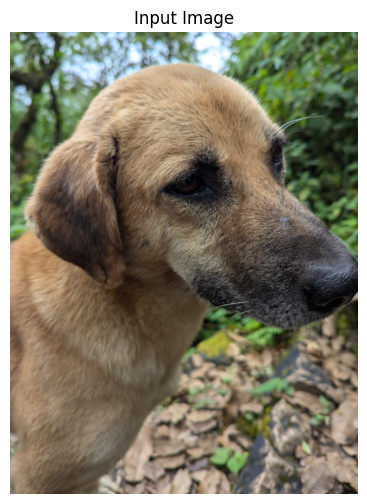

TOP PREDICTION: Chesapeake_Bay_retriever (55.3%)


In [93]:
your_dog_image_path = "./dog4.jpeg"

predicted_breed, confidence = display_prediction(
    your_dog_image_path, 
    model
)


In [87]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dog_predictions(model, test_dataset, label_encoder, num_samples=10):
    """
    Plot dog images with predictions (for MobileNetV2 preprocessing).
    Images are in [-1, 1] range from preprocess_input.
    """
    
    # Collect samples
    test_images = []
    test_labels = []
    
    for images, labels in test_dataset.unbatch().take(1000):
        test_images.append(images.numpy())
        test_labels.append(labels.numpy())
    
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    # Random selection
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    sample_images = test_images[indices]
    sample_labels = test_labels[indices]
    
    # Predictions
    predictions = model.predict(sample_images, verbose=0)
    predicted_indices = np.argmax(predictions, axis=1)
    predicted_probs = np.max(predictions, axis=1)
    
    # Plot
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()
    
    for i in range(num_samples):
        ax = axes[i]
        
        # Display image correctly - convert from [-1, 1] to [0, 1] for matplotlib
        img_to_show = sample_images[i].copy()
        
        # Convert from [-1, 1] to [0, 1]
        img_to_show = (img_to_show + 1.0) / 2.0
        img_to_show = np.clip(img_to_show, 0, 1)
        
        ax.imshow(img_to_show)
        ax.axis('off')
        
        # Breed names
        true_breed = label_encoder.inverse_transform([sample_labels[i]])[0]
        pred_breed = label_encoder.inverse_transform([predicted_indices[i]])[0]
        confidence = predicted_probs[i] * 100
        
        # Color
        color = 'green' if predicted_indices[i] == sample_labels[i] else 'red'
        
        # Shorten long breed names
        if len(true_breed) > 15:
            true_breed = true_breed[:12] + "..."
        if len(pred_breed) > 15:
            pred_breed = pred_breed[:12] + "..."
        
        ax.set_title(f"True: {true_breed}\nPred: {pred_breed}\n({confidence:.1f}%)", 
                    color=color, fontsize=11, pad=10)
    
    plt.suptitle("Dog Breed Predictions (Green = Correct, Red = Incorrect)", 
                fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

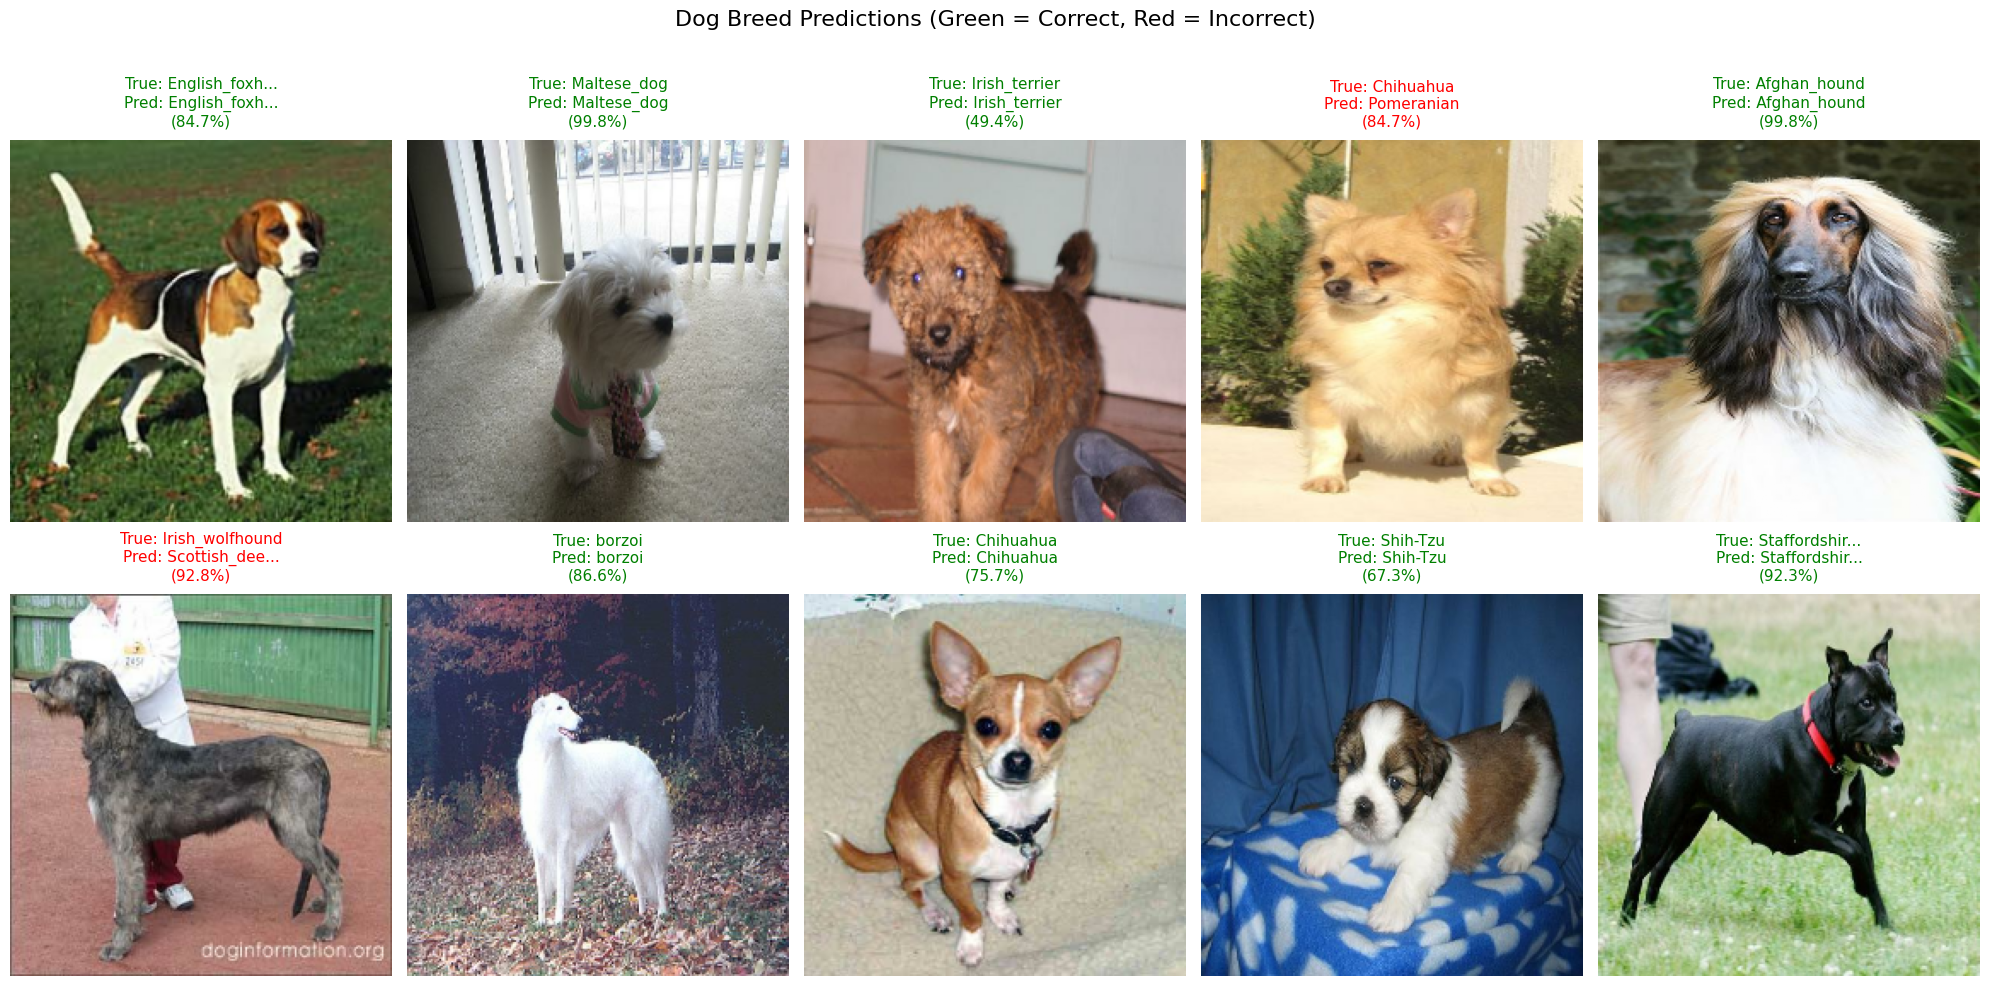

In [89]:
plot_dog_predictions(model_phase2, test_dataset, label_encoder)


In [ ]:
from skl